In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/all_gazeta

/content/drive/MyDrive/all_gazeta


In [ ]:
!pip install bigartm10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
import artm

from tqdm import trange

In [ ]:
!sudo apt-get --reinstall install ttf-mscorefonts-installer

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ubuntu-advantage-tools ubuntu-pro-client
  ubuntu-pro-client-l10n ubuntu-release-upgrader-core update-manager-core
  update-notifier-common xfonts-encodings xfonts-utils zstd
Suggested packages:
  shunit2
The following NEW packages will be installed:
  cabextract distro-info libfontenc1 libmspack0 python3-chardet
  python3-debconf python3-debian python3-distro-info python3-distupgrade
  python3-update-manager python3-yaml ttf-mscorefonts-installer
  ubuntu-advantage-tools ubuntu-pro-client ubuntu-pro-client-l10n
  ubuntu-release-upgrader-core update-manager-core update-notifier-common
  xfonts-encodings xfonts-utils zstd
0 upgraded, 21 newly installed, 0 to remove an

In [ ]:
import matplotlib.font_manager as fm
for fontpath in fm.findSystemFonts():
    fm.fontManager.addfont(fontpath)

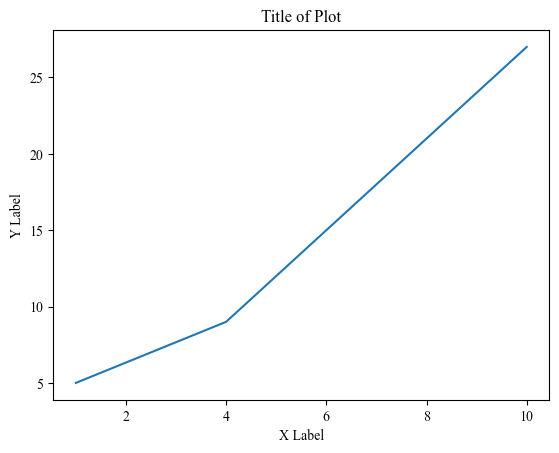

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Times New Roman'
#define x and y
x = [1, 4, 10]
y = [5, 9, 27]

#create line plot
plt.plot (x, y)

#add title and axis labels
plt.title('Title of Plot')
plt.xlabel('X Label')
plt.ylabel('Y Label')

#display plot
plt.show()

In [ ]:
def print_measures(model_plsa):
    print('Sparsity Phi: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (PLSA)'.format(
        model_plsa.score_tracker['PerplexityScore'].last_value))

In [ ]:
def print_scores(scores, save=None, many=False):
    print_measures(model_plsa)
    plt.figure()
    phi, theta = None, None
    if many:
        for scores_dict in scores:
            phi, = plt.plot(scores_dict['SparsityPhiScore'], 'r--', linewidth=2, alpha=0.3)
            theta, = plt.plot(scores_dict['SparsityThetaScore'], 'b--', linewidth=2, alpha=0.3)
    else:
        phi, = plt.plot(scores['SparsityPhiScore'].value, 'r--', linewidth=2)
        theta, = plt.plot(scores['SparsityThetaScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Sparsity')
    plt.legend([phi, theta], ['Phi sparsity', 'Theta sparsity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_sparsity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    contrast, purity = None, None
    if many:
        for scores_dict in scores:
            contrast, = plt.plot(scores_dict['TopicKernelScore'].average_contrast, 'r', linewidth=2, alpha=0.3)
            purity, = plt.plot(scores_dict['TopicKernelScore'].average_purity, 'b', linewidth=2, alpha=0.3)
    else:
        contrast, = plt.plot(scores['TopicKernelScore'].average_contrast, 'r', linewidth=2)
        purity, = plt.plot(scores['TopicKernelScore'].average_purity, 'b', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Contrast/Purity')
    plt.grid(True)
    plt.legend([contrast, purity], ['Average contrast', 'Average purity'])
    if save:
        plt.savefig(save+"_contrast_purity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

    plt.figure()
    perp = None
    if many:
        for scores_dict in scores:
            perp, = plt.plot(scores_dict['PerplexityScore'].value, 'b--', linewidth=2, alpha=0.3)
    else:
        perp, = plt.plot(scores['PerplexityScore'].value, 'b--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel('Perplexity')
    plt.xlim(1)
    plt.legend([perp], ['Model perplexity'])
    plt.grid(True)
    if save:
        plt.savefig(save+"_perplexity.eps", format='pdf', dpi=1000,
                    bbox_inches='tight', pad_inches=0)
    plt.show()

In [ ]:
batch_vectorizer = None
if len(glob.glob(os.path.join('gazeta_batches', '*.batch'))) < 1:
  batch_vectorizer = artm.BatchVectorizer(data_path='gazeta', data_format='bow_uci',
                                                collection_name='gazeta', target_folder='gazeta_batches')
else:
  batch_vectorizer = artm.BatchVectorizer(data_path='gazeta_batches', data_format='batches')

In [ ]:
if not os.path.isfile('gazeta_batches/my_dictionary.dict'):
  dictionary = artm.Dictionary()
  dictionary.gather(data_path='gazeta_batches')
  dictionary.save(dictionary_path='gazeta_batches/my_dictionary')
  dictionary.load(dictionary_path='gazeta_batches/my_dictionary.dict')
else:
  dictionary = artm.Dictionary()
  dictionary.load(dictionary_path='gazeta_batches/my_dictionary.dict')

In [ ]:
parameters = {
    'num_topics': 200,
    'num_collection_passes': 20,
    'num_document_passes': 1
}

num_topics = parameters['num_topics']
num_collection_passes = parameters['num_collection_passes']
num_document_passes = parameters['num_document_passes']

topic_names = ['@topic_'+str(i) for i in range(num_topics)]

In [ ]:
model_plsa = artm.ARTM(topic_names=topic_names, cache_theta=True)

model_plsa.initialize(dictionary=dictionary)

tokens_class = "@default_class"
model_plsa.class_ids = {tokens_class: 1.0}

model_plsa.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                               dictionary=dictionary))
model_plsa.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
#model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

In [ ]:
model_plsa.num_document_passes = num_document_passes

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.003 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.569 (PLSA)
Kernel purity: 0.034 (PLSA)
Perplexity: 5553.768 (PLSA)


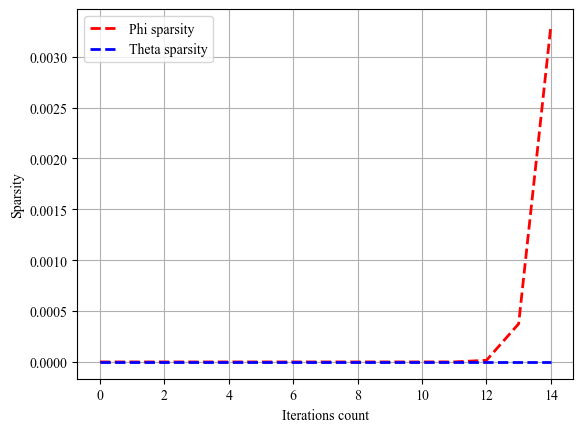

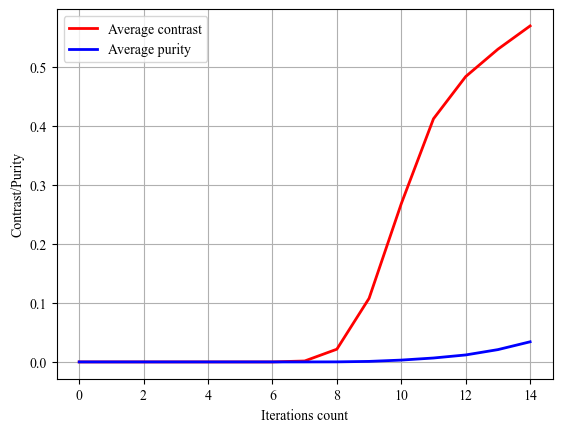

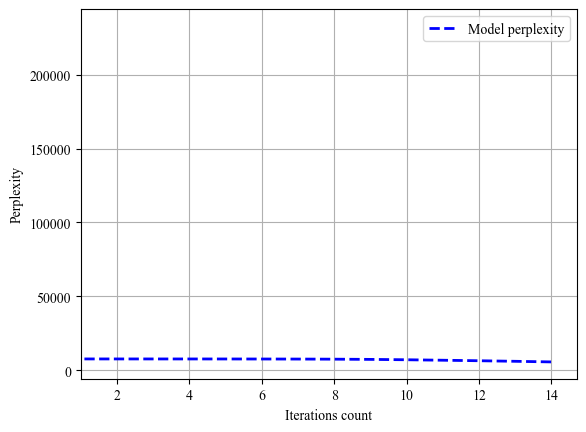

In [ ]:
print_scores(model_plsa.score_tracker, save=None, many=False)

In [ ]:
#model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))

model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

Sparsity Phi: 0.511 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.767 (PLSA)
Kernel purity: 0.205 (PLSA)
Perplexity: 3346.087 (PLSA)


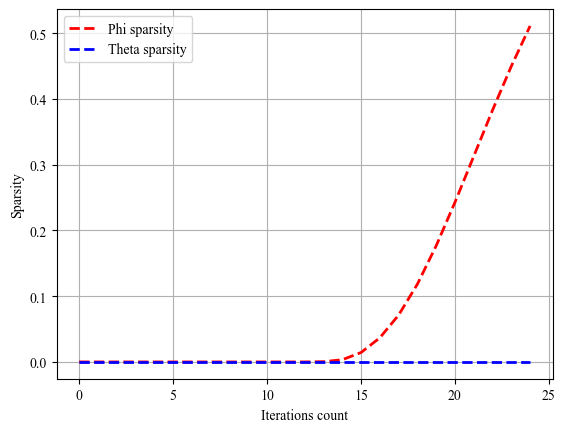

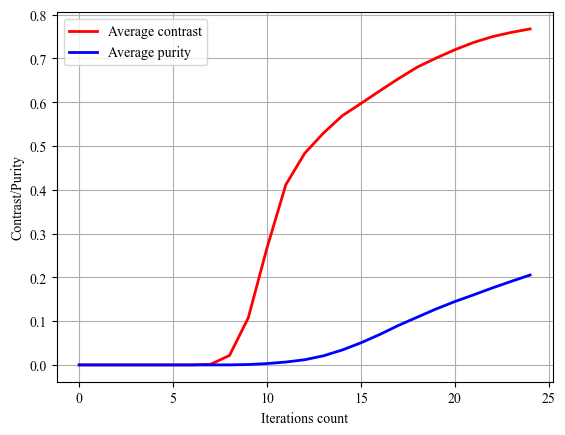

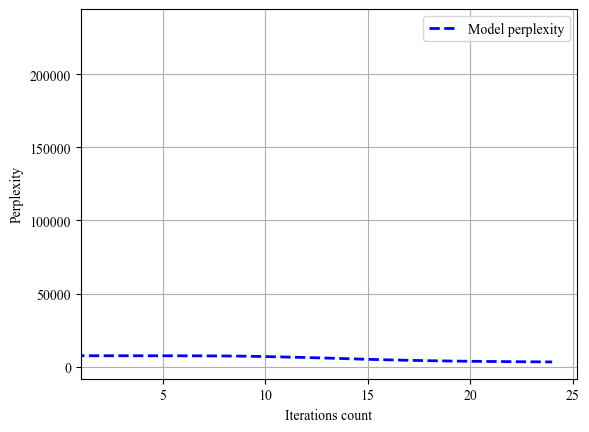

In [ ]:
print_scores(model_plsa.score_tracker, save=None, many=False)

In [ ]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Sparsity Phi: 0.916 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.795 (PLSA)
Kernel purity: 0.613 (PLSA)
Perplexity: 2987.517 (PLSA)


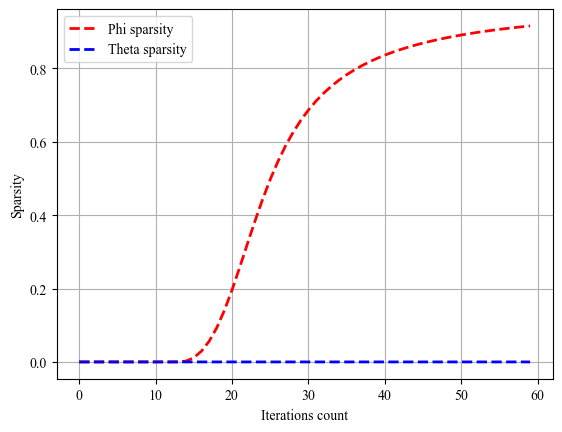

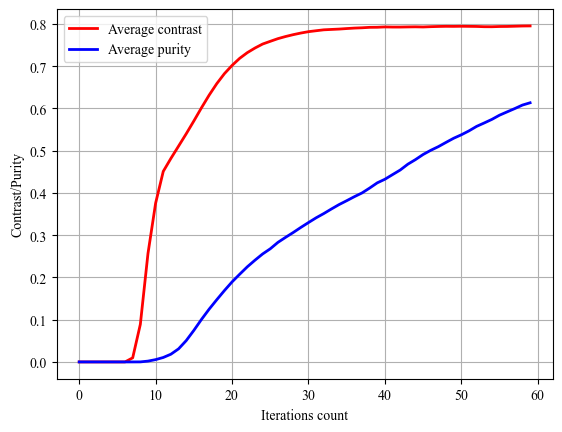

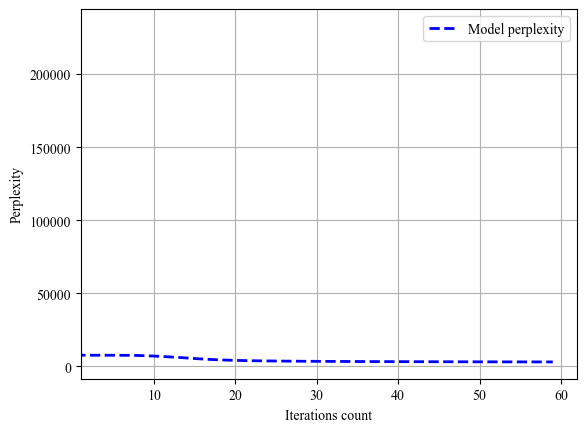

In [ ]:
print_scores(model_plsa.score_tracker, save='Gazeta-PLSA', many=False)

In [ ]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

Sparsity Phi: 0.815 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.789 (PLSA)
Kernel purity: 0.342 (PLSA)
Perplexity: 2885.381 (PLSA)


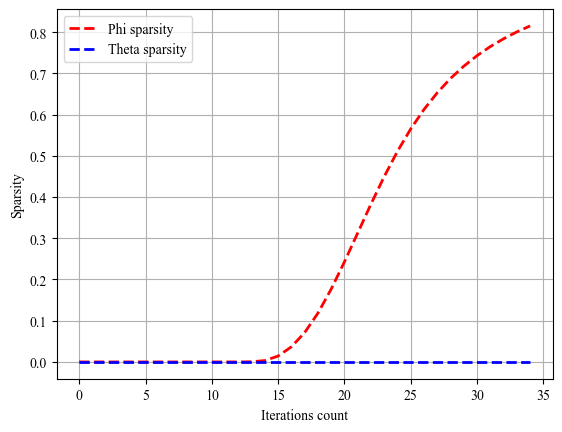

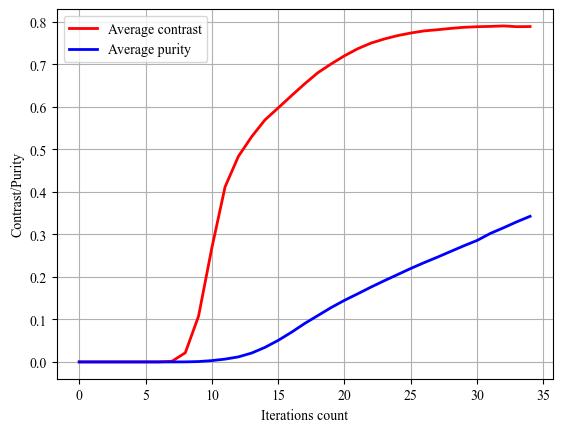

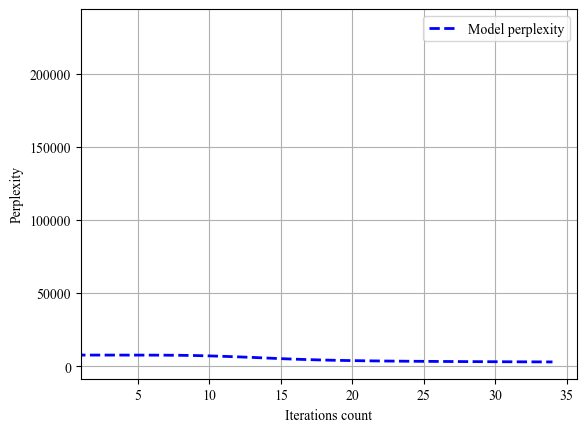

In [ ]:
print_scores(model_plsa.score_tracker, save='Gazeta-PLSA', many=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sparsity Phi: 0.866 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.793 (PLSA)
Kernel purity: 0.411 (PLSA)
Perplexity: 2750.519 (PLSA)


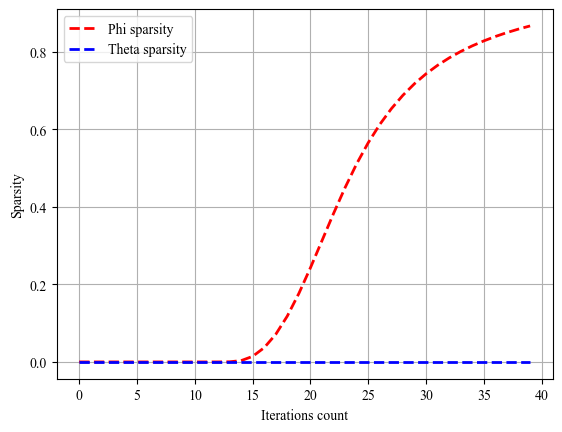

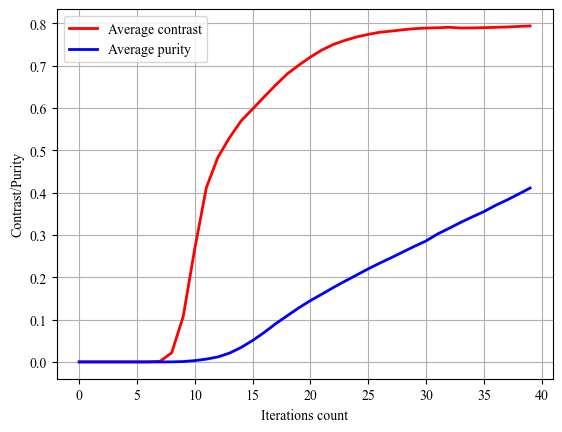

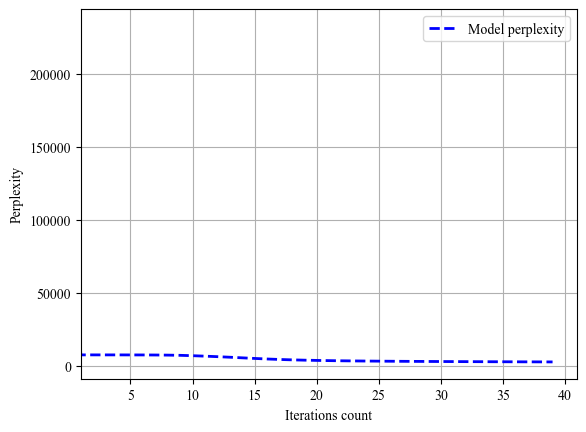

In [ ]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_scores(model_plsa.score_tracker, save=None, many=False)

Sparsity Phi: 0.897 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.795 (PLSA)
Kernel purity: 0.486 (PLSA)
Perplexity: 2641.938 (PLSA)


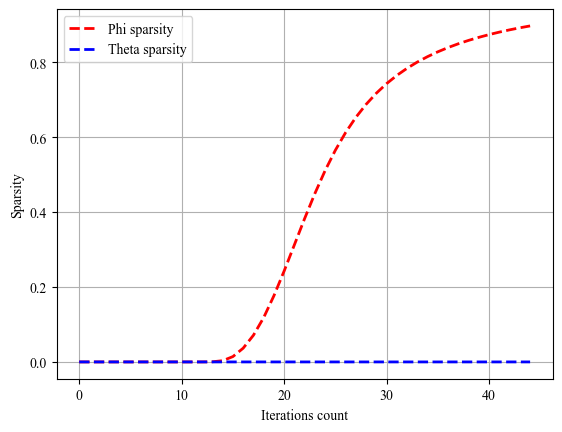

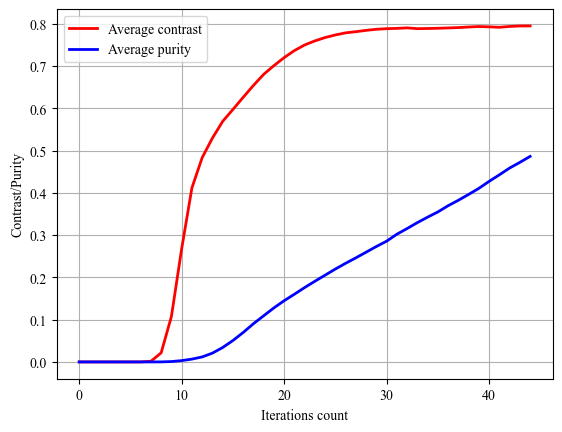

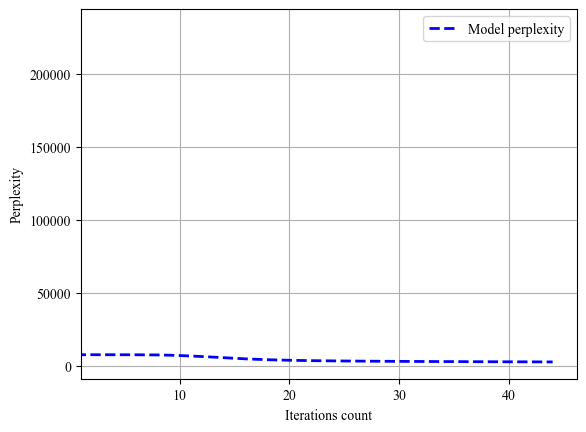

In [ ]:
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_scores(model_plsa.score_tracker, save=None, many=False)

Sparsity Phi: 0.920 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.797 (PLSA)
Kernel purity: 0.581 (PLSA)
Perplexity: 2531.292 (PLSA)


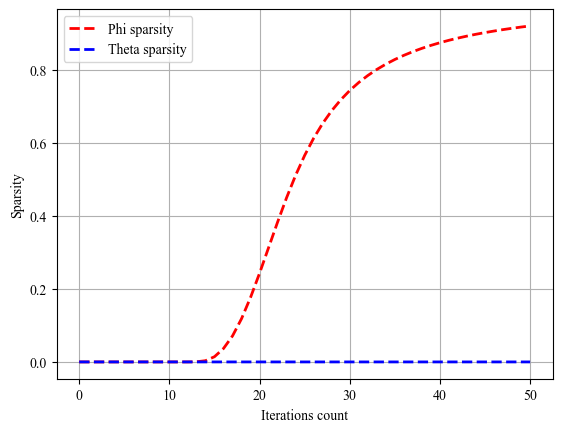

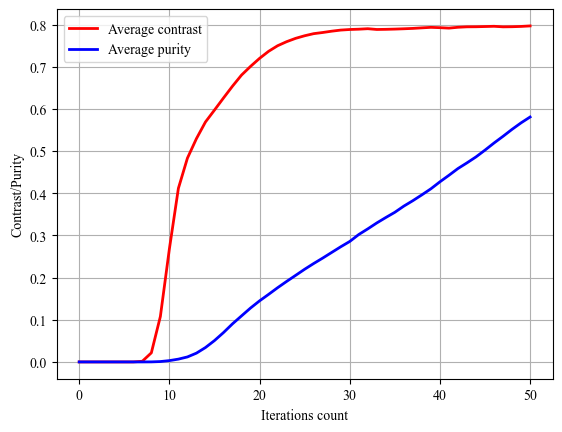

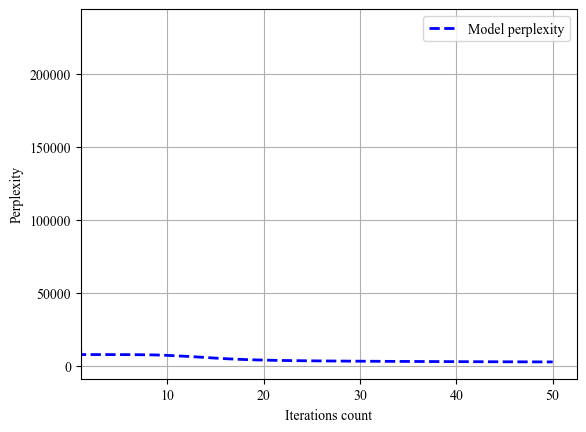

In [ ]:
print_scores(model_plsa.score_tracker, save='Gazeta-PLSA', many=False)

Sparsity Phi: 0.932 (PLSA)
Sparsity Theta: 0.000 (PLSA)
Kernel contrast: 0.798 (PLSA)
Kernel purity: 0.654 (PLSA)
Perplexity: 2456.708 (PLSA)


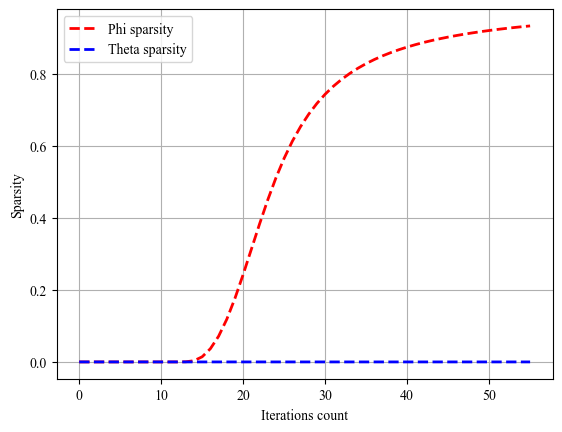

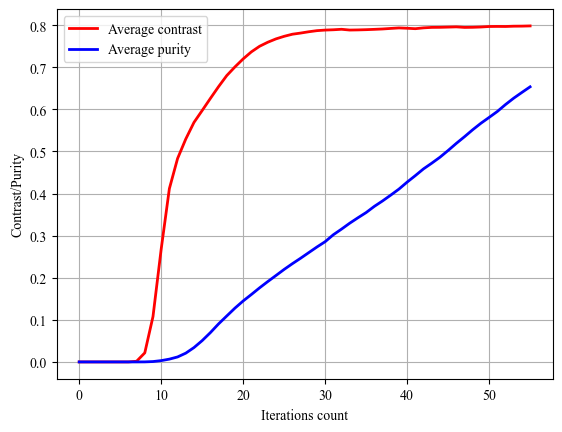

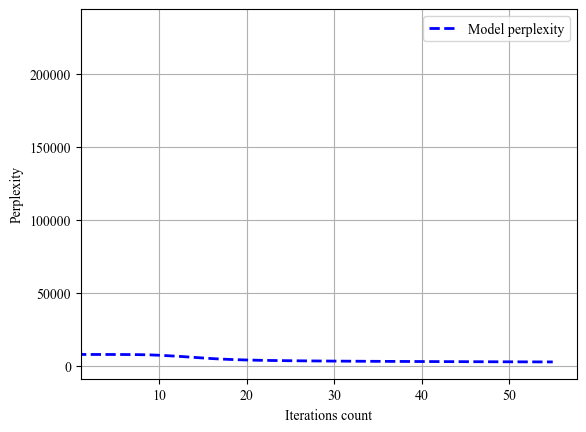

In [ ]:
model_plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=15))
model_plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)
print_scores(model_plsa.score_tracker, save='Gazeta-PLSA', many=False)

In [ ]:
for topic_name in model_plsa.topic_names:
    print(topic_name + ': ')
    print(model_plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

@topic_0: 
['врач', 'исследователь', 'лечение', 'болезнь', 'пациент', 'исследование', 'мозг', 'заболевание', 'организм', 'ученый', 'доктор', 'медицинский', 'клиника', 'рак', 'боль']
@topic_1: 
['президент', 'владимир', 'путин', 'глава', 'секретарь', 'кремль', 'песок', 'государство', 'пресс', 'саммит', 'обсуждать', 'послание', 'песков', 'визит', 'заявлять']
@topic_2: 
['ведущий', 'поведение', 'критика', 'скандал', 'повод', 'высказывание', 'отреагировать', 'высказываться', 'задавать', 'вызывать', 'реакция', 'скандальный', 'раскритиковывать', 'возмущаться', 'извиняться']
@topic_3: 
['нато', 'альянс', 'запад', 'присутствие', 'союзник', 'совместный', 'угроза', 'учение', 'усиливать', 'усиление', 'действие', 'агрессия', 'база', 'оборона', 'агрессивный']
@topic_4: 
['рынок', 'торговый', 'товар', 'объем', 'продукция', 'торговля', 'производство', 'производитель', 'экспорт', 'пошлина', 'предприятие', 'промышленность', 'отрасль', 'потребитель', 'продукт']
@topic_5: 
['море', 'судно', 'находиться',

In [ ]:
phi = model_plsa.get_phi(class_ids=[tokens_class]).values

In [ ]:
def get_corr_matrix(phi):
    df = pd.DataFrame(phi)
    return df.corr()

corr_matrix = get_corr_matrix(phi).values

In [ ]:
def plot_corr_matrix(matrix, save=None):
    f, ax = plt.subplots(figsize=(50, 20))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(matrix, cmap='Greens', vmin=0.0,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title('Topic-topic correlation matrix')
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)

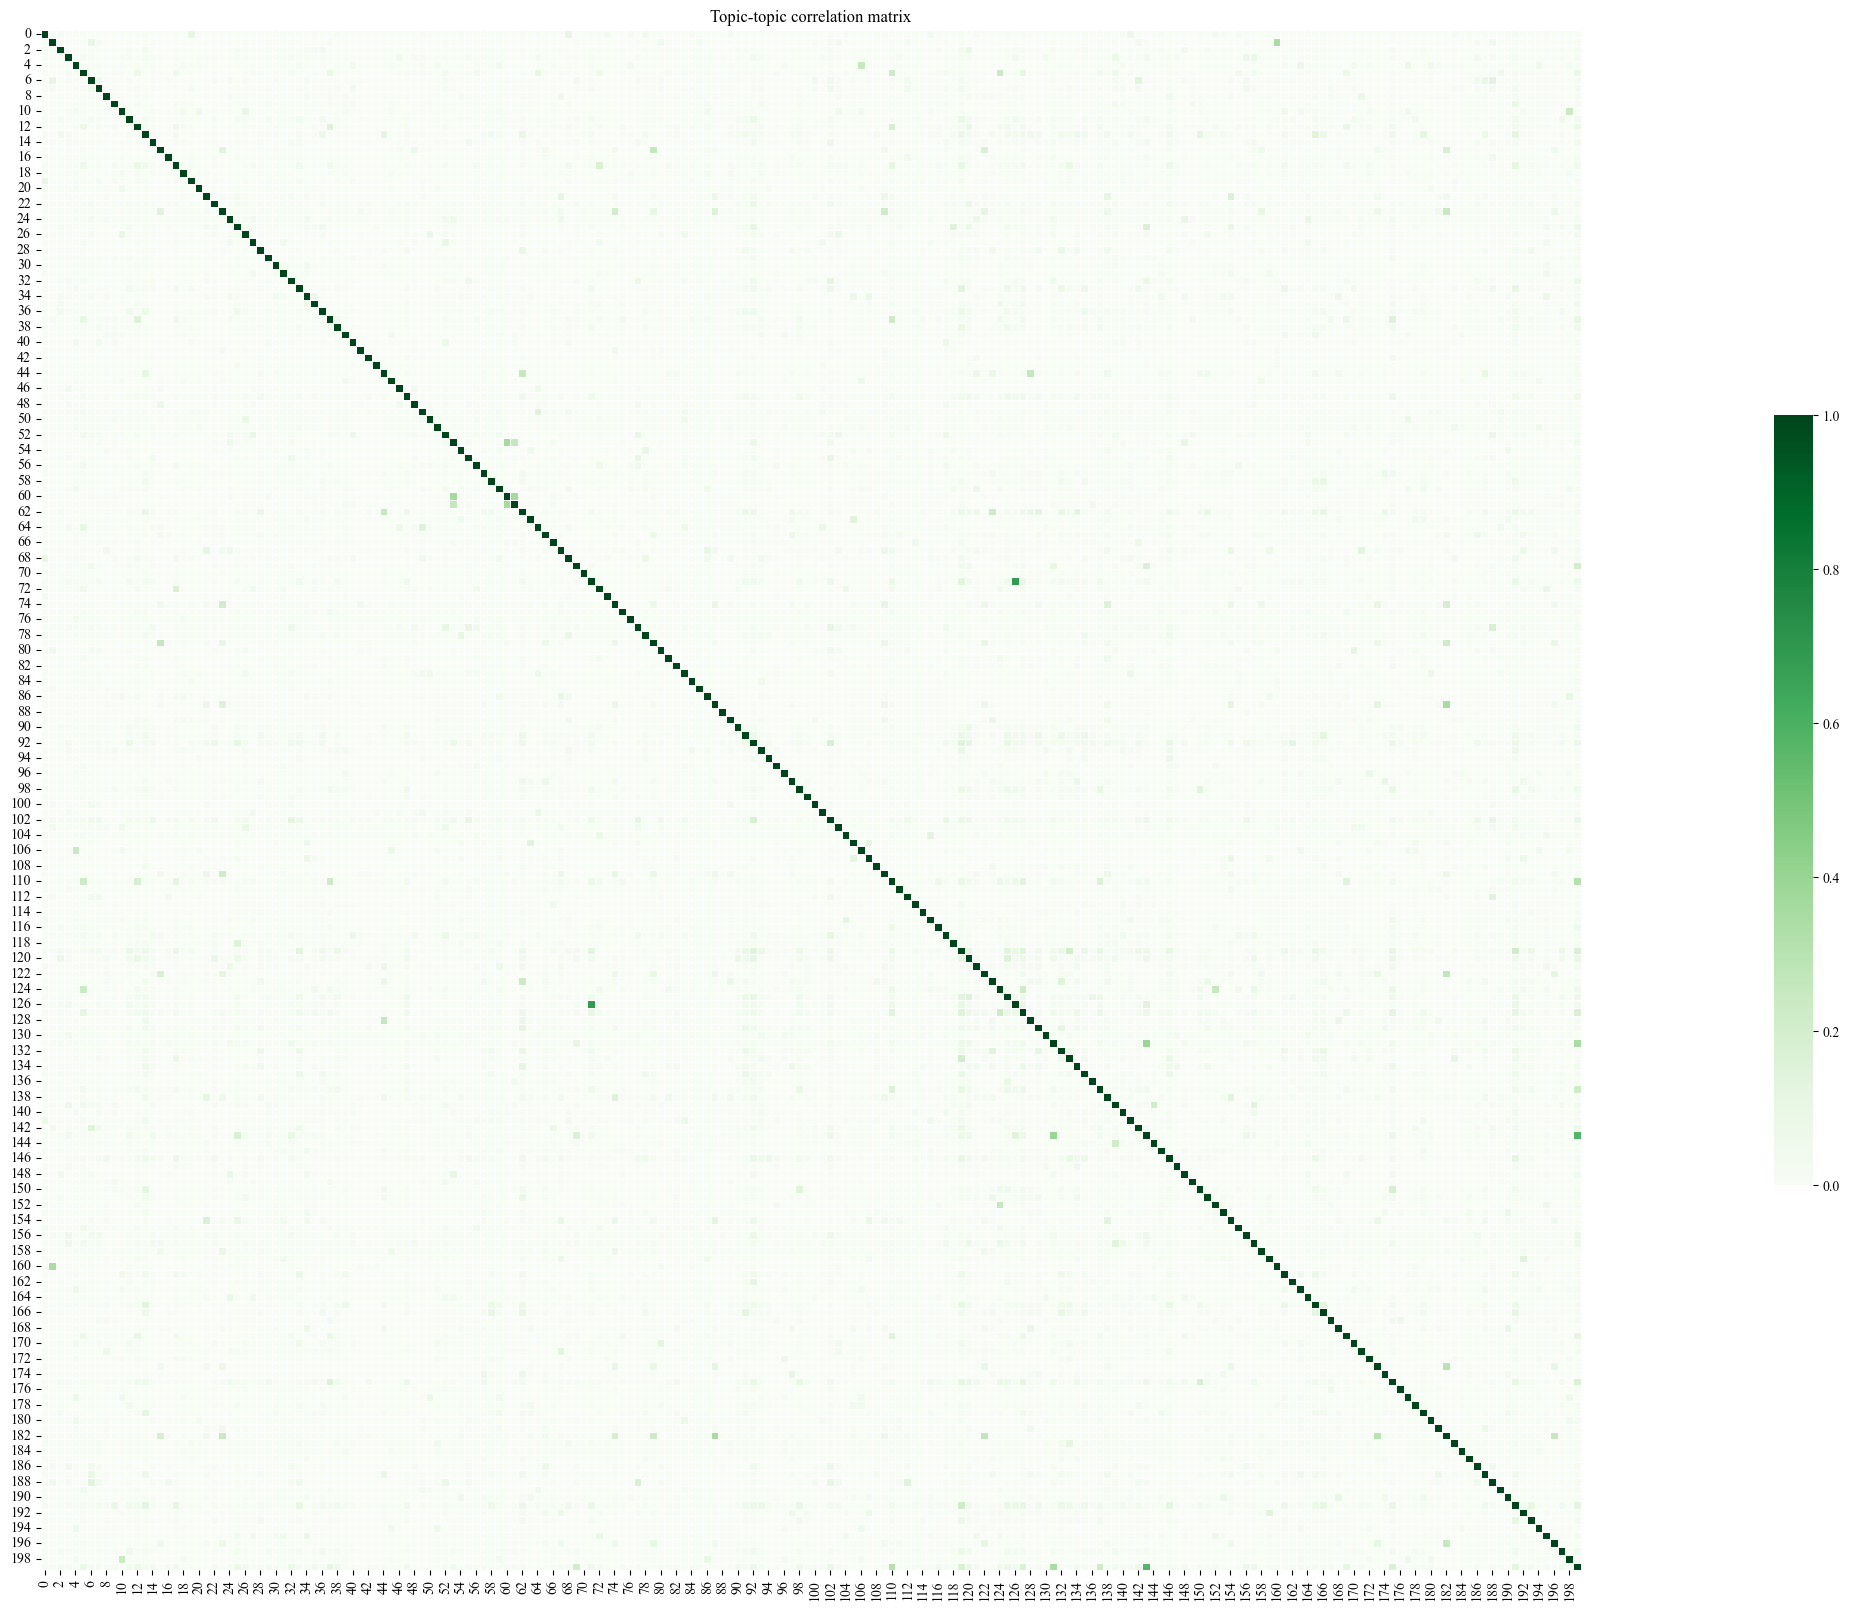

In [ ]:
plot_corr_matrix(corr_matrix, save='Gazeta-PLSA_corr.eps')

In [ ]:
theta = model_plsa.get_theta().values
phi = model_plsa.get_phi().values

In [ ]:
def plot_matrix(matrix, figsize=(20,15), xlabel='', ylabel='', title='', save=None):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.binary)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    if save:
        plt.savefig(save, format='eps', dpi=1000, bbox_inches='tight', pad_inches=0)
    print(np.any(np.isnan(matrix)))

<>:2: DeprecationWarning: invalid escape sequence '\T'


False


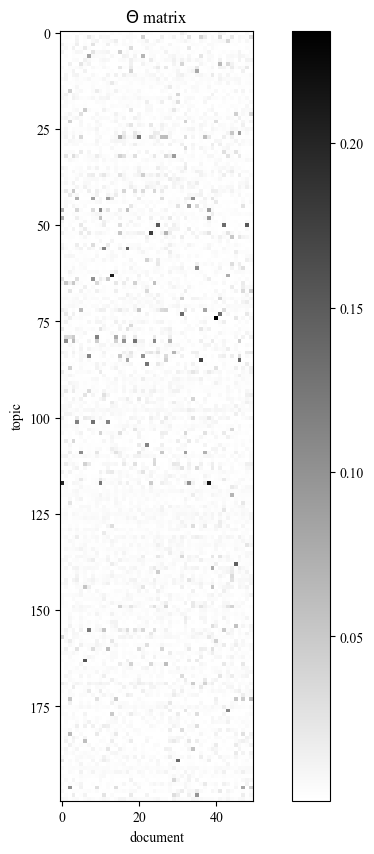

In [ ]:
plot_matrix(theta[:,:50], figsize=(10,10), xlabel='document', ylabel='topic',
            title='$\Theta$ matrix', save='Gazeta-PLSA_Theta.eps')

<>:2: DeprecationWarning: invalid escape sequence '\P'


False


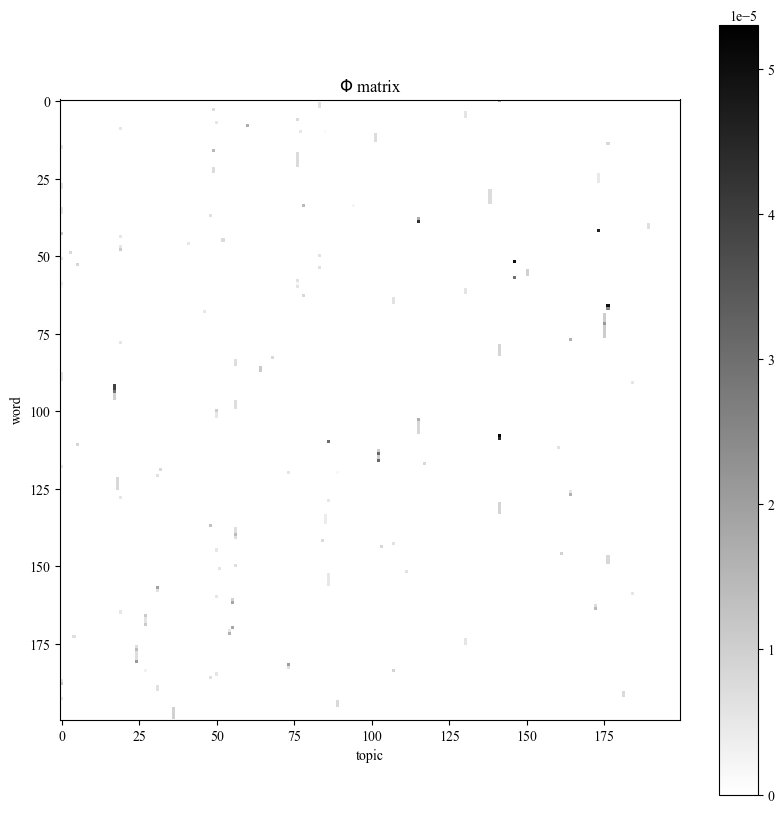

In [ ]:
plot_matrix(phi[:200,:], figsize=(10,10), xlabel='topic', ylabel='word',
            title='$\Phi$ matrix', save='Gazeta-PLSA_Phi.eps')